# Import

In [1]:
import sys
from pathlib import Path

##os.getcwd()
if "../scripts/" not in sys.path:  # to prevent multyadding  
    sys.path.append("../scripts/") 
# types
import pickle
import time

# work with data
import numpy as np
import pandas as pd
from sklearn.utils import resample
import tensorflow as tf

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from data_handle import data_dir, read_configuration, normalize_images
from data_handle import img_prepare, predict_img_tflite, predict_img_tf, evaluate_tflite_model
from helpers import print_imgs

# Load data

In [7]:
CONFIG, PATHS, EMOTIONS = read_configuration(data_dir / "config.yaml")
# model_65_file = './checkpoints/model_MobNetLike/1v1-noregdepwisw_dropout0.2/cp_model-E0181--val_acc0.6573--val_loss1.1014.keras'

## TF model

In [10]:
model = tf.keras.models.load_model(PATHS['model_path'])

In [11]:
img_shape = model.input_shape[1:3]
img_dtype = model.input_dtype
f'{img_shape=}, {img_dtype=}'

"img_shape=(48, 48), img_dtype='float32'"

## Quantized model

In [ ]:
interpreter_lite_model = tf.lite.Interpreter(model_path=PATHS['tflite_model_path'].as_posix())

c:\Users\alena\AI\emotions-detector\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [7]:
interpreter_input_details = interpreter_lite_model.get_input_details()[0]
interpreter_input_details

{'name': 'serving_default_input_layer_2:0',
 'index': 0,
 'shape': array([ 1, 48, 48,  1], dtype=int32),
 'shape_signature': array([-1, 48, 48,  1], dtype=int32),
 'dtype': numpy.float32,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [8]:
interpreter_output_details = interpreter_lite_model.get_output_details()[0]
interpreter_output_details

{'name': 'StatefulPartitionedCall_1:0',
 'index': 193,
 'shape': array([1, 7], dtype=int32),
 'shape_signature': array([-1,  7], dtype=int32),
 'dtype': numpy.float32,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

## Test set

In [ ]:
X_test, y_test_onehot = np.load(PATHS['res_dir'] / 'X_test.npy'), np.load(PATHS['res_dir'] / 'y_test_onehot.npy')
X_test, y_test_onehot = resample(X_test, y_test_onehot, replace=False, n_samples=1000, stratify=y_test_onehot)

# Tests

## Image preparation
Test different functions to resize an image, to expand dimentions and convert it to different data type.  


### Function to test  
Structure of the functions names:  
`img_prepare_<resize_method>[_<expand_method>]`, where
- <resize_method>==cv2 => use cv2.resize
- <resize_method>==tf => use tf.image.resize
- <expand_method> is omitted => use np.newaxis to expand
- <expand_method>==ex => use np.expand_dims

In [10]:
def img_prepare_cv2(img:np.ndarray, flt_type:np.dtype|None=None):
    img = normalize_images(img)
    img = cv2.resize(img, img_shape)[np.newaxis,:,:,np.newaxis]
    if flt_type is not None: # convert after resize, because cv2.resize doesn't support float16
        img = img.astype(flt_type)
    return img

In [11]:
def img_prepare_cv2_ex(img:np.ndarray, flt_type:np.dtype|None=None):
    img = normalize_images(img)
    img = cv2.resize(img, img_shape)
    if flt_type is not None: # convert after resize, because cv2.resize doesn't support float16
        img = img.astype(flt_type)
    img = np.expand_dims(img, axis=-1)  # add channel dimension
    img = np.expand_dims(img, axis=0)  # add batch dimension
    return img

In [12]:
def img_prepare_tf(img:np.ndarray, flt_type:np.dtype|None=None):
    img = normalize_images(img)
    if flt_type is not None:
        img = img.astype(flt_type)
    img = tf.image.resize(img[np.newaxis,:,:,np.newaxis], img_shape)  # resize to (1, H, W, C)
    return img

In [13]:
def img_prepare_tf_ex(img:np.ndarray, flt_type:np.dtype|None=None):
    img = normalize_images(img)
    if flt_type is not None:
        img = img.astype(flt_type)
    img = tf.expand_dims(img, axis=-1)  # (H, W, C)
    img = tf.expand_dims(img, axis=0)  # (1, H, W, C)
    img = tf.image.resize(img, img_shape)  
    return img

### Collect images

In [14]:
#load the pre-trained Haar Cascade classifier
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

def get_face(vid):
    gray_image = cv2.cvtColor(vid, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray_image, 1.1, 7, minSize=(40, 40))
    if len(faces) == 0:
        return None, (0,0,0,0)
    
    x, y, w, h = faces[0]
    return gray_image[y:y + h, x:x + w], (x, y, w, h)

In [15]:
def collect_faces(num=12, max_error_faces_recognition=120):
    video_capture = cv2.VideoCapture(0)
    not_recognized=0
    frequency = int(video_capture.get(cv2.CAP_PROP_FPS))//2
    frame_count = frequency
    faces = []
    faces_counter = 0
    while faces_counter < num:
        result, video_frame = video_capture.read()  # read frames from the video
        if result is False:
            break  # terminate the loop if the frame is not read successfully
  
        face, _ = get_face(video_frame)  
        if face is not None:
            
            if frame_count==frequency:
                frame_count=0
                faces.append(face)
                faces_counter += 1
            
            frame_count += 1
        else:
            not_recognized += 1
            if not_recognized>max_error_faces_recognition:
                break
  
        # Display the resulting frame 
        cv2.imshow('video', video_frame) 
    
        # creating 'q' as the quit  
        # button for the video 
        if cv2.waitKey(1) & 0xFF == ord('q'): 
            break
    video_capture.release()
    cv2.destroyAllWindows()
    return faces, not_recognized

def test_img_prepare(imgs, func, *args, **kwargs):
    timings = np.zeros(len(imgs), dtype=np.float32)
    for i, img in enumerate(imgs):
        start = time.perf_counter()
        tmp = func(img, *args, **kwargs)
        end = time.perf_counter()
        timings[i] = end - start
    return timings


In [ ]:
faces_test_file_path = PATHS['res_dir'] / 'faces_test.npy'
if faces_test_file_path.exists():
    with open(faces_test_file_path, 'rb') as f:
        faces = pickle.load(f)
else:
    faces, not_recognized = collect_faces()
    print(f"Collected {len(faces)} faces, not recognized: {not_recognized}")
    with open(faces_test_file_path, 'wb') as f:
        pickle.dump(faces, f)
    print(f'Images loaded from {faces_test_file_path.resolve()}')

### Testing

In [42]:
funcs_to_test = [img_prepare_cv2, img_prepare_cv2_ex, img_prepare_tf, img_prepare_tf_ex]
types = [None, np.float32, np.float16]
timings = {}
for prep_func in funcs_to_test:
    for tp in types:
        print(f"Testing {prep_func.__name__} with type {tp}")
        timing = test_img_prepare(faces, prep_func, tp)
        timings_key = f"{prep_func.__name__}_{tp.__name__ if tp else 'None(float64)'}"
        timings[timings_key] = timing
df = pd.DataFrame(timings)


Testing img_prepare_cv2 with type None
Testing img_prepare_cv2 with type <class 'numpy.float32'>
Testing img_prepare_cv2 with type <class 'numpy.float16'>
Testing img_prepare_cv2_ex with type None
Testing img_prepare_cv2_ex with type <class 'numpy.float32'>
Testing img_prepare_cv2_ex with type <class 'numpy.float16'>
Testing img_prepare_tf with type None
Testing img_prepare_tf with type <class 'numpy.float32'>
Testing img_prepare_tf with type <class 'numpy.float16'>
Testing img_prepare_tf_ex with type None
Testing img_prepare_tf_ex with type <class 'numpy.float32'>
Testing img_prepare_tf_ex with type <class 'numpy.float16'>


Print the tests results:

In [43]:
df.rename(columns={col: col.replace("img_prepare_", "") for col in df.columns}, inplace=True)
df

,cv2_None(float64),cv2_float32,cv2_float16,cv2_ex_None(float64),cv2_ex_float32,cv2_ex_float16,tf_None(float64),tf_float32,tf_float16,tf_ex_None(float64),tf_ex_float32,tf_ex_float16
0,0.002311,0.000293,0.000689,0.000256,0.000199,0.000195,0.129689,0.056114,0.001724,0.003782,0.001184,0.029144
1,0.000469,0.000178,0.000665,0.000205,0.000573,0.000571,0.002920,0.001039,0.002167,0.003142,0.001032,0.001432
2,0.000296,0.000155,0.000340,0.000152,0.000234,0.000289,0.001596,0.000766,0.001446,0.001867,0.002689,0.001474
3,0.000201,0.000192,0.000208,0.000161,0.000198,0.000216,0.002170,0.000997,0.002065,0.001277,0.001825,0.001478
4,0.000170,0.000244,0.000168,0.000140,0.000196,0.000463,0.001213,0.001138,0.007765,0.001122,0.001673,0.001711
5,0.000597,0.000221,0.000251,0.000167,0.000307,0.000354,0.001646,0.001072,0.001674,0.001053,0.001216,0.001694
6,0.000247,0.000157,0.000206,0.000116,0.000259,0.000424,0.001067,0.000875,0.001394,0.000966,0.001128,0.004387
7,0.000483,0.000146,0.000148,0.000111,0.000178,0.000227,0.001052,0.000832,0.003252,0.001173,0.000959,0.001725
8,0.001211,0.000146,0.000163,0.000123,0.000136,0.000209,0.002820,0.000778,0.001186,0.001082,0.001022,0.001215
9,0.000194,0.000113,0.000116,0.000121,0.000139,0.000246,0.000967,0.003051,0.006830,0.000998,0.000968,0.001164


In [44]:
df.mean().sort_values(ascending=True).round(6).to_frame("mean").T

,cv2_ex_None(float64),cv2_float32,cv2_ex_float32,cv2_float16,cv2_ex_float16,cv2_None(float64),tf_ex_float32,tf_ex_None(float64),tf_ex_float16,tf_float16,tf_float32,tf_None(float64)
mean,0.000151,0.000176,0.000222,0.000271,0.000317,0.000604,0.0013,0.001523,0.004067,0.007152,0.007355,0.01239


### Plot the test results

In [20]:
# melt the df to the long formate to use with sns plot methods
df_long = df.reset_index(names='num').melt(id_vars='num', var_name='preparation', value_name='time')
df_long['resizer'] = df_long['preparation'].apply(lambda x: x.split('_')[0])
df_long['type'] = df_long['preparation'].apply(lambda x: x.split('_')[-1])
df_long['expand_dims'] = df_long['preparation'].apply(lambda x: 'ex' in x)
df_long[10:14]

,num,preparation,time,resizer,type,expand_dims
10,10,cv2_None(float64),0.000105,cv2,None(float64),False
11,11,cv2_None(float64),0.000092,cv2,None(float64),False
12,0,cv2_float32,0.000156,cv2,float32,False
13,1,cv2_float32,0.000139,cv2,float32,False


In [21]:
def save_plot(file_name: Path):
    plt.savefig(file_name)
    # plt.show()
    plt.close()
    print(f"Plot saved to {file_name.resolve()}") 

In [ ]:
data_to_plot = df_long[df_long['num'] > 0].copy() # the first try is usualy the longest one for every preparation, so we skip it to have more fair comparison
plot = sns.relplot(data=data_to_plot, x='num', y='time', hue='preparation', col='resizer', kind='line', col_wrap=2, height=4)
save_plot(PATHS['res_dir'] / 'timings_img_prepare_cv2_vs_tf.png')

sns.lineplot(data=data_to_plot, x='num', y='time', hue='resizer')
plt.title('Image preparation time for different methods(agregate by resizers)')
save_plot(PATHS['res_dir'] / 'timings_img_prepare_cv2_vs_tf_one_plot.png')

sns.relplot(data=data_to_plot, x='num', y='time', hue='resizer', col='type', kind='line', col_wrap=3, height=4)
save_plot(PATHS['res_dir'] / 'timings_img_prepare_compare_types.png')

sns.relplot(data=data_to_plot, x='num', y='time', hue='resizer', col='type', row='expand_dims', kind='line', height=4, facet_kws=dict(margin_titles=True))
save_plot(PATHS['res_dir'] / 'timings_img_prepare_compare_types_expand_dims.png')

Plot saved to C:\Users\alena\AI\emotions-detector\results\timings_img_prepare_cv2_vs_tf.png
Plot saved to C:\Users\alena\AI\emotions-detector\results\timings_img_prepare_cv2_vs_tf_one_plot.png
Plot saved to C:\Users\alena\AI\emotions-detector\results\timings_img_prepare_compare_types.png
Plot saved to C:\Users\alena\AI\emotions-detector\results\timings_img_prepare_compare_types_expand_dims.png


In [ ]:
data_to_plot_cv2 = data_to_plot[(data_to_plot['resizer']=='cv2')].copy()
fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharey=True, gridspec_kw={'wspace': 0}, )
sns.lineplot(data=data_to_plot_cv2, x='num', y='time', hue='type', style='expand_dims', ax=axs[0])
sns.lineplot(data=data_to_plot_cv2, x='num', y='time', hue='expand_dims', ax=axs[1])
sns.lineplot(data=data_to_plot_cv2, x='num', y='time', hue='type', ax=axs[2])
save_plot(PATHS['res_dir'] / 'timings_img_prepare_cv2_3kind.png')

sns.relplot(data=data_to_plot_cv2, x='num', y='time', hue='type', col='expand_dims', kind='line', height=4)
save_plot(PATHS['res_dir'] / 'timings_img_prepare_cv2_type_line.png')

sns.relplot(data=data_to_plot_cv2, x='num', y='time', hue='expand_dims', col='type', kind='line', height=4)
save_plot(PATHS['res_dir'] / 'timings_img_prepare_cv2_expand_dims_line.png')


Plot saved to C:\Users\alena\AI\emotions-detector\results\timings_img_prepare_cv2_3kind.png
Plot saved to C:\Users\alena\AI\emotions-detector\results\timings_img_prepare_cv2_type_line.png
Plot saved to C:\Users\alena\AI\emotions-detector\results\timings_img_prepare_cv2_expand_dims_line.png


Save combined image of all plots

In [ ]:
files = sorted(
    [f for f in PATHS['res_dir'].glob('timings_img_prepare_*_*.png')],
    key=lambda f: f.stat().st_mtime,
    reverse=False  # from oldest to newest
)
imgs = [Image.open(img) for img in files]

# get plots' sizes
widths, heights = zip(*(img.size for img in imgs))
total_height = sum(heights)
max_width = max(widths)

combined_img = Image.new("RGB", (max_width, total_height), color=(255, 255, 255)) # white background

# Paste each image into the combined image one under another
y_offset = 0
for img in imgs:
    combined_img.paste(img, (0, y_offset))
    y_offset += img.size[1]

file_name = PATHS['res_dir'] / "timings_img_prepare_compare.png"
combined_img.save(file_name)
print(f"Plots comparing preparation timings saved to {file_name.resolve()}")

Plots comparing preparation timings saved to C:\Users\alena\AI\emotions-detector\results\timings_img_prepare_compare.png


### Chosen prepare function
I will use img_prepare_cv2 with type <class 'numpy.float32'> to prepare the images. Rewrite it to use with float32 only. 

In [48]:
img_prepare_local = lambda img: img_prepare(img, img_shape=img_shape, flt_type=np.float32)

In [56]:
timings = test_img_prepare(faces, img_prepare_local)

In [57]:
df_to_plot = pd.concat([pd.Series(timings),
                        df['cv2_float32']], keys=['simple func', 'cv2_float32'], axis=0, names=['preparation', 'num']).rename('time').reset_index()
df_to_plot[10:14]

,preparation,num,time
10,simple func,10,0.000099
11,simple func,11,0.000080
12,cv2_float32,0,0.000293
13,cv2_float32,1,0.000178


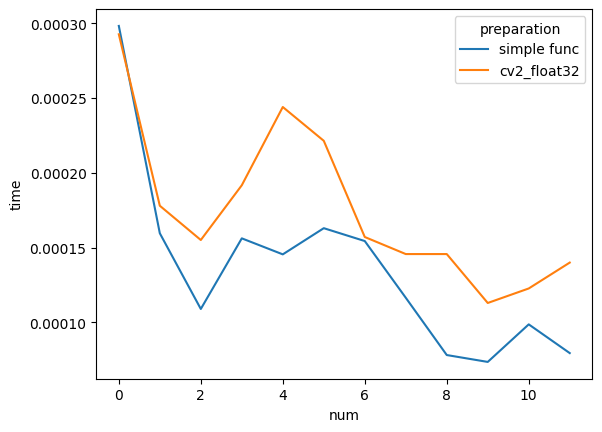

In [58]:
sns.lineplot(data=df_to_plot, x='num', y='time', hue='preparation')
plt.show()

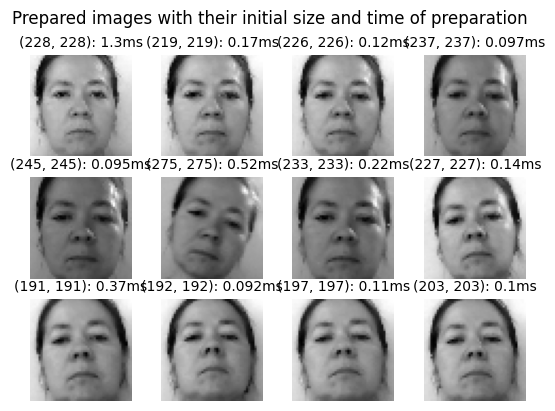

In [55]:
_ = print_imgs(list((img_prepare(face)[0] for face in faces)), 
           labels=(f'{face.shape}:{time_prp*1000: .2}ms' for face, time_prp in zip(faces, timings)), 
           cols=4, figsize=(6.5, 4.5), title="Prepared images with their initial size and time of preparation", label_size=10)

## Compare tf and tflite models

In [59]:
# use predict functions with current parameters - model and interpreter, so that they depend on image only
predict_img_tf_local = lambda img: predict_img_tf(img, model=model, img_shape=img_shape, flt_type=np.float32, img_prepare_fn=img_prepare)
predict_img_tflite_local = lambda img: predict_img_tflite(img, interpreter=interpreter_lite_model,
                                                          input_index=interpreter_input_details['index'], output_index=interpreter_output_details['index'],
                                                          img_shape=img_shape, flt_type=np.float32, img_prepare_fn=img_prepare)

### Prediction time

In [64]:
timing = test_img_prepare(faces, predict_img_tf_local)
timing_lite = test_img_prepare(faces, predict_img_tflite_local)
df_timing = pd.DataFrame({'tf': timing, 'tflite': timing_lite}, index=range(len(timing)))
df_timing.mean().sort_values(ascending=True).round(6).to_frame("mean").T

,tflite,tf
mean,0.032677,0.419164


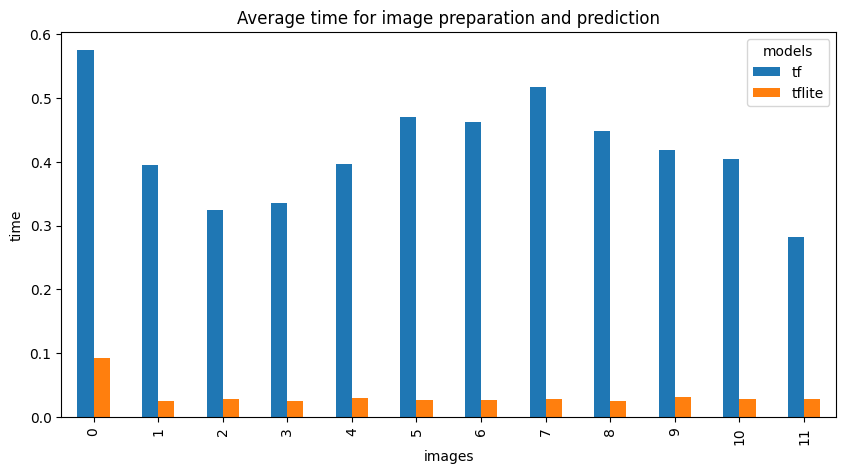

In [65]:
df_timing.rename_axis('models', inplace=True, axis=1)
df_timing.plot(kind='bar', figsize=(10, 5), title='Average time for image preparation and prediction', xlabel='images', ylabel='time', label='time', )
plt.show()

### Metrics

In [66]:
print('tf model')
eval_tf = model.evaluate(X_test, y_test_onehot, verbose=1, return_dict=True)
print('tflite model')
eval_tflite = evaluate_tflite_model(interpreter_lite_model, X_test, y_test_onehot, metrics="accuracy", return_dict=True)

tf model
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 347ms/step - accuracy: 0.5759 - loss: 1.5947
tflite model
................................
{'categorical_accuracy': np.float32(0.568), 'loss': np.float32(1.3655312)}


In [67]:
df = pd.DataFrame([eval_tf, {k.split('_')[-1]:v for k,v in eval_tflite.items()}], index=['tf', 'tf_lite'])
df

,accuracy,loss
tf,0.564,1.549809
tf_lite,0.568,1.365531
